In [8]:
# for PyTorch SpatialRandomForest 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
# for sklearn SpatialRandomForest 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report

### Read contents of AEGISDataset

In [26]:
# Read the CSV file into a DataFrame
data = pd.read_csv('../aegis_flood_data/AEGISDataset_SJOIN_merged_cleaned.csv')

In [6]:
# Display the first few rows of the DataFrame
print("Data Head:")
print(data.head())

Data Head:
   Unnamed: 0        lat         lon  flood_height  elevation  precipitation  \
0           0  14.640394  121.055708             0  54.553295            9.0   
1           1  14.698299  121.002132             0  21.856272           10.0   
2           2  14.698858  121.100261             0  69.322807           16.0   
3           3  14.571310  120.983334             0  10.987241            8.0   
4           4  14.762232  121.075735             0  87.889847           18.0   

   is_flooding                         geometry  hazard_level  
0            0  POINT (121.0557085 14.64039374)           0.0  
1            0  POINT (121.0021322 14.69829935)           0.0  
2            0  POINT (121.1002614 14.69885841)           0.0  
3            0  POINT (120.9833345 14.57131006)           0.0  
4            0   POINT (121.0757349 14.7622323)           0.0  


In [7]:
# Display information on about the DataFrame
print("\nData Info:")
print(data.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     3511 non-null   int64  
 1   lat            3511 non-null   float64
 2   lon            3511 non-null   float64
 3   flood_height   3511 non-null   int64  
 4   elevation      3511 non-null   float64
 5   precipitation  3511 non-null   float64
 6   is_flooding    3511 non-null   int64  
 7   geometry       3511 non-null   object 
 8   hazard_level   3511 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 247.0+ KB
None


### Spatial Random Forest Regression Model (PyTorch)

In [9]:
# Define PyTorch Model
class SpatialRandomForest(nn.Module):
    def __init__(self, input_dim):
        super(SpatialRandomForest, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  # Sigmoid for binary output
        return x

### Simulate Spatial Random Forest Regression Model (PyTorch)

In [10]:
# Step 1: Load and Preprocess Data
# data = pd.read_csv('../aegis_flood_data/AEGISDataset_SJOIN_merged_cleaned.csv')

# Exclude unnecessary columns
if 'geometry' in data.columns:
    data = data.drop(columns=['geometry'])
    
if 'flood_height' in data.columns:
    data = data.drop(columns=['flood_height'])

# Specify columns
spatial_features = ['lat', 'lon']
predictor_columns = [col for col in data.columns if col not in ['is_flooding', 'lat', 'lon']]
target_column = 'is_flooding'

# Prepare feature matrix (X) and target vector (y)
X = data[spatial_features + predictor_columns].values
y = data[target_column].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize model
input_dim = X_train.shape[1]
model = SpatialRandomForest(input_dim)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the Model
num_epochs = 100
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Calculate training accuracy
    train_pred = (outputs >= 0.5).float()
    train_accuracy = (train_pred == y_train_tensor).float().mean().item()

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

        # Calculate test accuracy
        test_pred = (test_outputs >= 0.5).float()
        test_accuracy = (test_pred == y_test_tensor).float().mean().item()

    # Store losses and accuracies for plotting
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Print metrics every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# Step 4: Evaluate the Model and Map Out Predictions
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Inverse scaling for interpretation
y_pred = y_pred.flatten()

# Calculate performance metrics
mse = np.mean((y_pred - y_test) ** 2)
print(f"Test MSE: {mse:.4f}")

# Step 5: Final Evaluation on Test Set
model.eval()
with torch.no_grad():
    final_test_outputs = model(X_test_tensor)
    final_test_pred = (final_test_outputs >= 0.5).float()
    final_test_accuracy = (final_test_pred == y_test_tensor).float().mean().item()

print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Epoch [10/100], Train Loss: 0.5391, Test Loss: 0.5332, Train Acc: 0.8251, Test Acc: 0.8293
Epoch [20/100], Train Loss: 0.3941, Test Loss: 0.3824, Train Acc: 0.9231, Test Acc: 0.9374
Epoch [30/100], Train Loss: 0.2713, Test Loss: 0.2573, Train Acc: 0.9637, Test Acc: 0.9716
Epoch [40/100], Train Loss: 0.1870, Test Loss: 0.1768, Train Acc: 0.9740, Test Acc: 0.9716
Epoch [50/100], Train Loss: 0.1362, Test Loss: 0.1302, Train Acc: 0.9772, Test Acc: 0.9716
Epoch [60/100], Train Loss: 0.1055, Test Loss: 0.1029, Train Acc: 0.9808, Test Acc: 0.9758
Epoch [70/100], Train Loss: 0.0858, Test Loss: 0.0858, Train Acc: 0.9840, Test Acc: 0.9758
Epoch [80/100], Train Loss: 0.0722, Test Loss: 0.0744, Train Acc: 0.9865, Test Acc: 0.9772
Epoch [90/100], Train Loss: 0.0622, Test Loss: 0.0662, Train Acc: 0.9868, Test Acc: 0.9801
Epoch [100/100], Train Loss: 0.0545, Test Loss: 0.0600, Train Acc: 0.9893, Test Acc: 0.9787
Final Test Accuracy: 0.9787


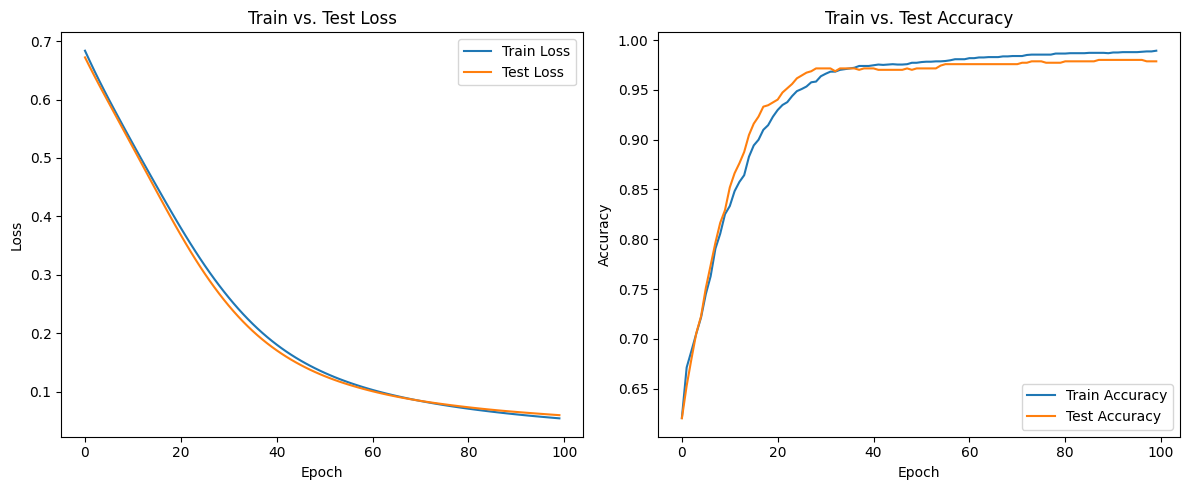

In [11]:
# Plot Training and Test Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs. Test Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs. Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

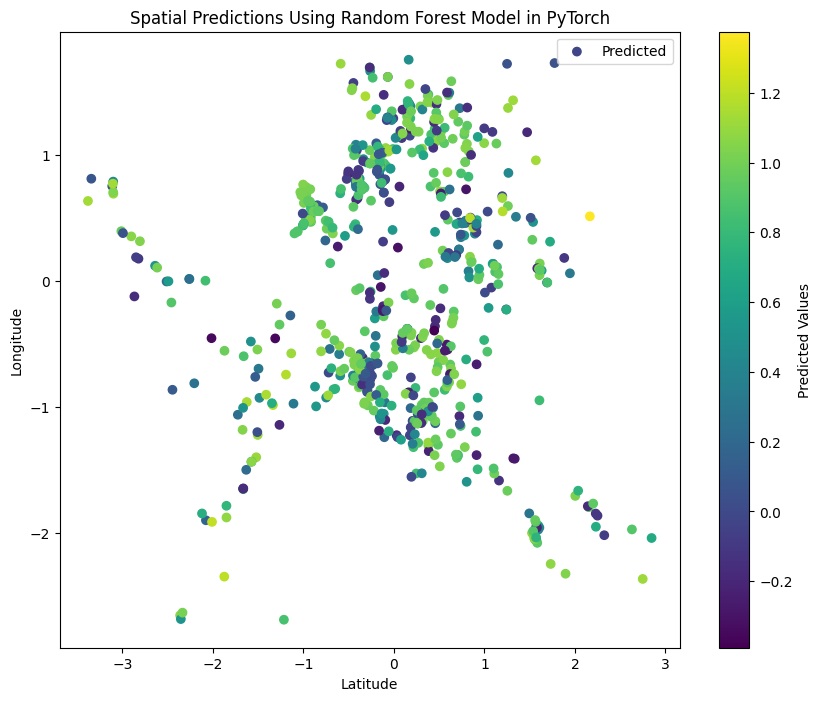

In [13]:
# Visualization
# Assuming latitude and longitude are columns 0 and 1 in X_test
plt.figure(figsize=(10, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', marker='o', label='Predicted')
plt.colorbar(label='Predicted Values')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Predictions Using Random Forest Model in PyTorch')
plt.legend()
plt.show()

### Simulate Spatial Random Forest Regression Model (sklearn)

In [21]:
# Exclude unnecessary columns (e.g., 'geometry' and 'flood_height' if not required)
data = data.drop(columns=['geometry'], errors='ignore')
data = data.drop(columns=['flood_height'], errors='ignore')

# Specify columns: Adjust these based on your dataset's actual column names
spatial_features = ['lat', 'lon']  # Spatial features
target_column = 'is_flooding'      # Binary target column (flood or no flood)
predictor_columns = [col for col in data.columns if col not in [target_column, 'lat', 'lon']]

# Prepare feature matrix (X) and target vector (y)
X = data[spatial_features + predictor_columns].values
y = data[target_column].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (optional for non-tree models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Initialize and Train Models

# Random Forest Classifier for binary flood prediction
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Decision Tree Regressor (optional, if you have continuous flood intensity data)
# dt_model = DecisionTreeRegressor(random_state=42)
# dt_model.fit(X_train, y_train)

# Logistic Regression as an additional baseline model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Step 4: Evaluate Models on Test Data

# Random Forest Predictions and Evaluation
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)

# Logistic Regression Predictions and Evaluation
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_confusion = confusion_matrix(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression Confusion Matrix:\n", lr_confusion)

# Decision Tree Regression (only if continuous data is available)
# dt_predictions = dt_model.predict(X_test)
# dt_mse = mean_squared_error(y_test, dt_predictions)
# print("Decision Tree Regression MSE:", dt_mse)

Random Forest Classifier Accuracy: 1.0
Random Forest Confusion Matrix:
 [[269   0]
 [  0 434]]
Logistic Regression Accuracy: 0.9943100995732574
Logistic Regression Confusion Matrix:
 [[267   2]
 [  2 432]]


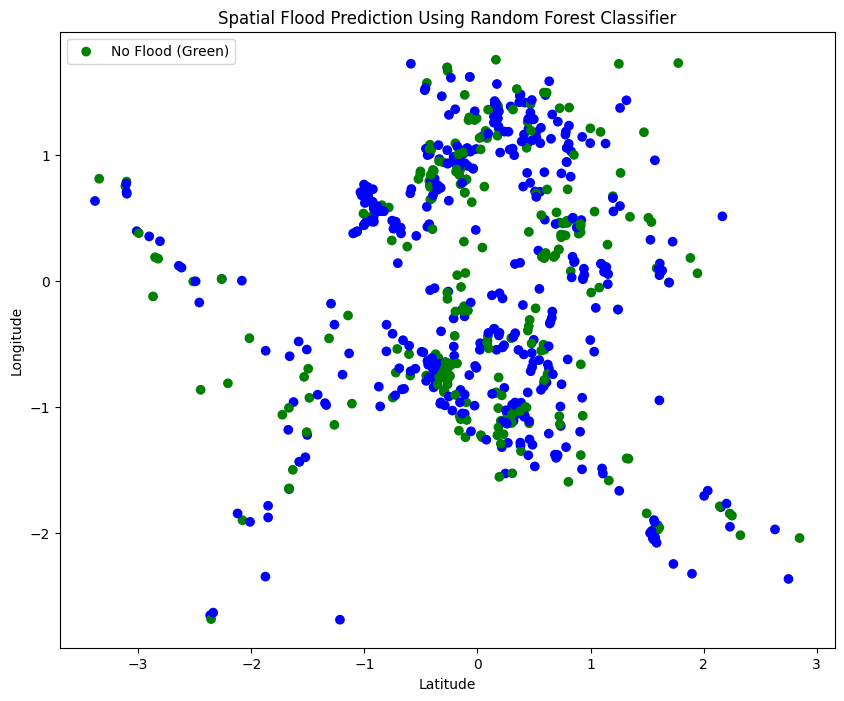

In [24]:
# Step 5: Visualize Spatial Predictions from Random Forest Model
# Assuming latitude and longitude are the first two columns in X_test
plt.figure(figsize=(10, 8))
colors = np.where(rf_predictions == 1, 'blue', 'green')
plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, marker='o', label='Predicted Flood')
# plt.colorbar(label='Flood Prediction')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Flood Prediction Using Random Forest Classifier')
plt.legend(['No Flood (Green)'])
plt.show()

### Simulate Spatial Random Forest Regression Model (sklearn) with optimization(?)

In [28]:
# Exclude unnecessary columns
data = data.drop(columns=['geometry'], errors='ignore')
data = data.drop(columns=['flood_height'], errors='ignore')

# Specify columns
spatial_features = ['lat', 'lon']
target_column = 'is_flooding'
predictor_columns = [col for col in data.columns if col not in [target_column, 'lat', 'lon']]

# Prepare feature matrix (X) and target vector (y)
X = data[spatial_features + predictor_columns].values
y = data[target_column].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (optional for non-tree models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 2: Hyperparameter Tuning with GridSearchCV for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 3: Train the Best Model and Evaluate Performance
best_rf_model.fit(X_train, y_train)

# Predict and Evaluate on Test Data
rf_predictions = best_rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)

print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)
print("Classification Report:\n", classification_report(y_test, rf_predictions))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Classifier Accuracy: 1.0
Random Forest Confusion Matrix:
 [[269   0]
 [  0 434]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       434

    accuracy                           1.00       703
   macro avg       1.00      1.00      1.00       703
weighted avg       1.00      1.00      1.00       703



In [29]:
# Feature Importance
feature_importances = best_rf_model.feature_importances_
feature_names = spatial_features + predictor_columns
sorted_indices = np.argsort(feature_importances)[::-1]

print("Feature Importance Ranking:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

Feature Importance Ranking:
Unnamed: 0: 0.9253
elevation: 0.0321
lat: 0.0176
lon: 0.0142
hazard_level: 0.0071
precipitation: 0.0037


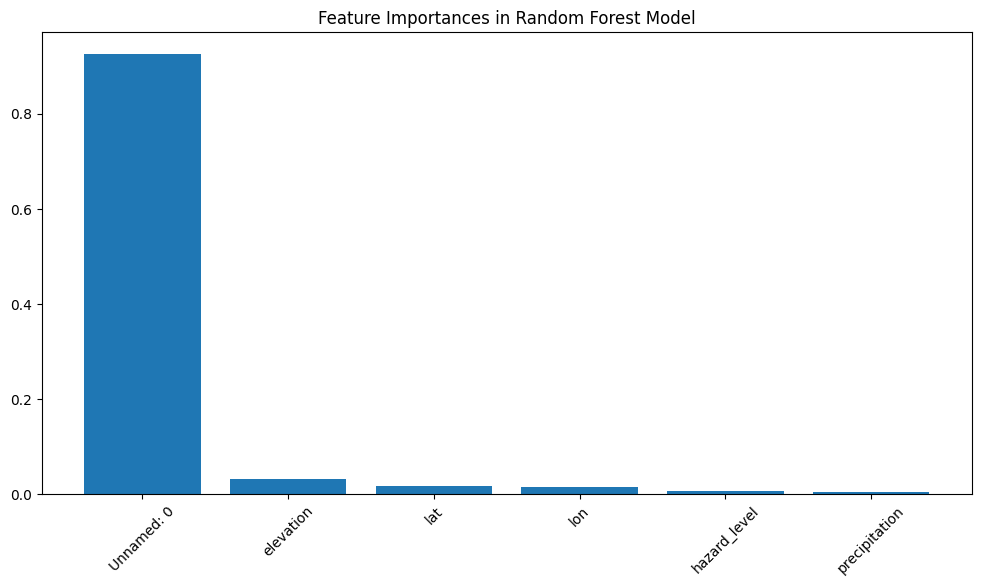

In [30]:
# Visualization of Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=45)
plt.title("Feature Importances in Random Forest Model")
plt.show()

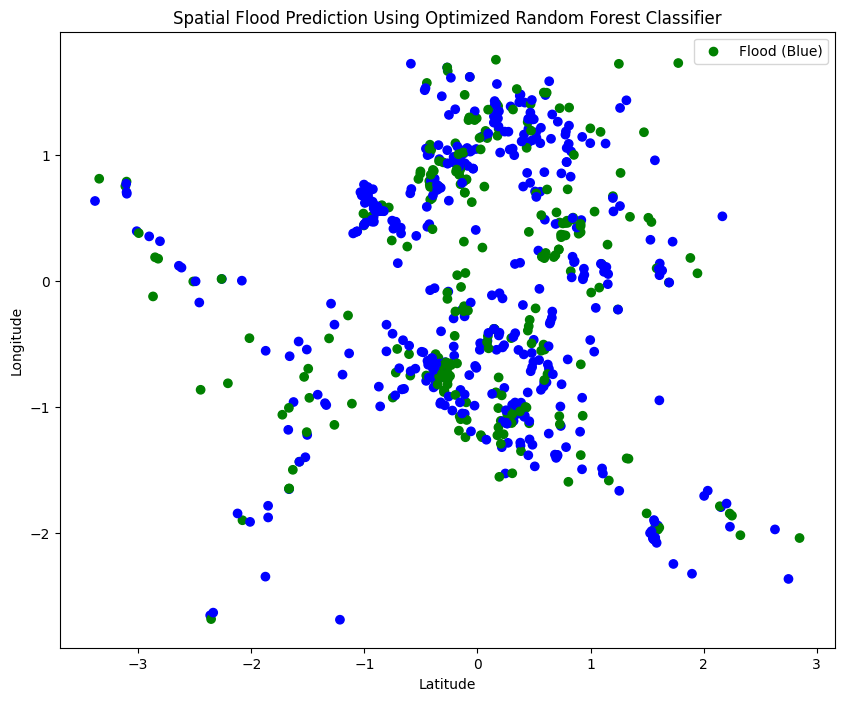

In [31]:
# Visualization of Spatial Predictions
colors = np.where(rf_predictions == 1, 'blue', 'green')
plt.figure(figsize=(10, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, marker='o', label='Predicted Flood')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Flood Prediction Using Optimized Random Forest Classifier')
plt.legend(['Flood (Blue)', 'No Flood (Green)'])
plt.show()